### **Minimum Cost Flow Network**

This is utilized as a tool to achieve balanced matching in an observational study; wherein its core idea is to frame the matching process as a network flow problem. The following are as defined and idientified:

>**Nodes**: Represent individual patients in the Interstitial Cystitis Data Base (ICDB).
>
>**Edges**: Represent potential matches between a treated patient and a control patient. An edge exists only if the control patient was not yet treated at the time the treated patient received the treatment (this is the "risk set" aspect).
>
>**Cost**: The "cost" associated with each edge represents the dissimilarity or distance between the treated and control patients in terms of their pretreatment characteristics (symptoms in this case). The Mahalanobis distance is used as a measure of this dissimilarity.
>
>**Flow**: The "flow" represents whether or not a particular match is selected. A flow of 1 means the match is made; a flow of 0 means it is not.

***Steps***

1. **Setting up the Network**: The authors construct a network where nodes represent patients, and edges represent permissible matches (treated patient points to an untreated patient).

2. **Defining Edge Costs**: The cost of each edge is calculated based on the Mahalanobis distance between the pretreatment symptom profiles of the treated and control patients.

3. **Applying Minimum Cost Flow**: The minimum cost flow algorithm is then used to find the set of matches (edges with flow = 1) that minimizes the total dissimilarity (total cost) across all matched pairs. This ensures that the matched pairs are as similar as possible.

4. **Balancing**: A penalty function within the integer programming framework is used to encourage balance in the marginal distributions of symptoms between the treated and control groups. This means they're not just trying to find similar pairs, but also ensure that the overall symptom profiles of the treated and control groups are comparable.



No feasible solution exists.
:: MINIMUM COST MATCHED PAIRS
      Treated_ID  Treated_Pain_Score  Treated_Urgency_Score  \
0      Patient_1                   3                      4   
1      Patient_5                   3                      4   
2      Patient_6                   1                      4   
3      Patient_7                   9                      5   
4     Patient_11                   2                      4   
..           ...                 ...                    ...   
139  Patient_292                   5                      3   
140  Patient_294                  10                      9   
141  Patient_295                   0                      8   
142  Patient_298                   8                      7   
143  Patient_300                   0                      7   

     Treated_Frequency_Score Untreated_ID  Untreated_Pain_Score  \
0                          2  Patient_197                     3   
1                          0   Patient_44         

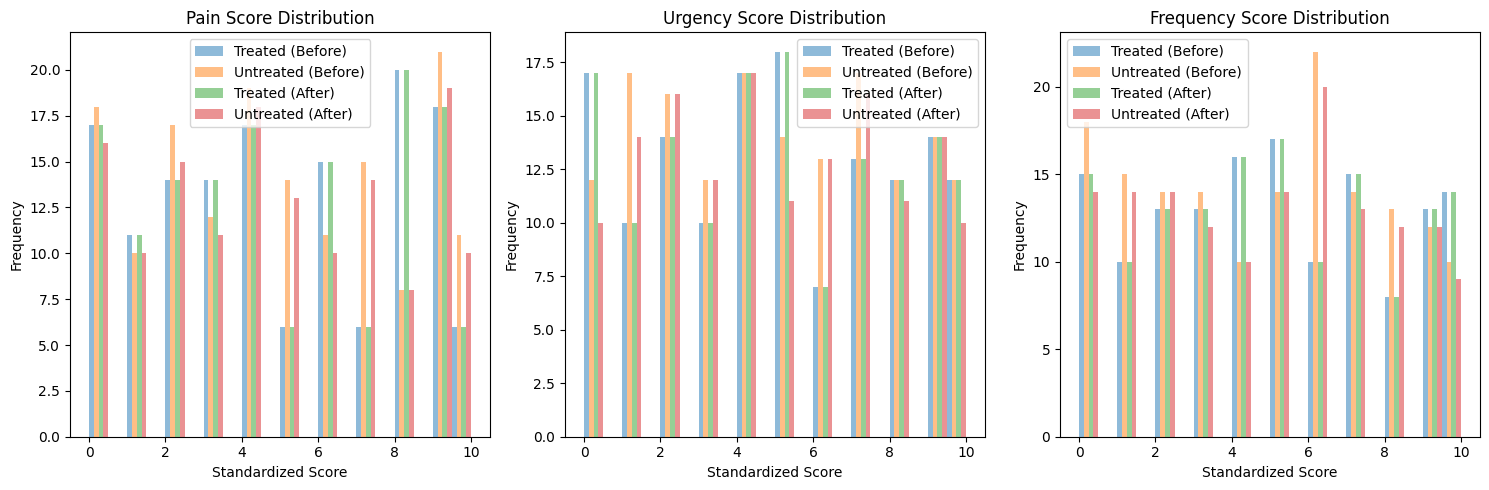

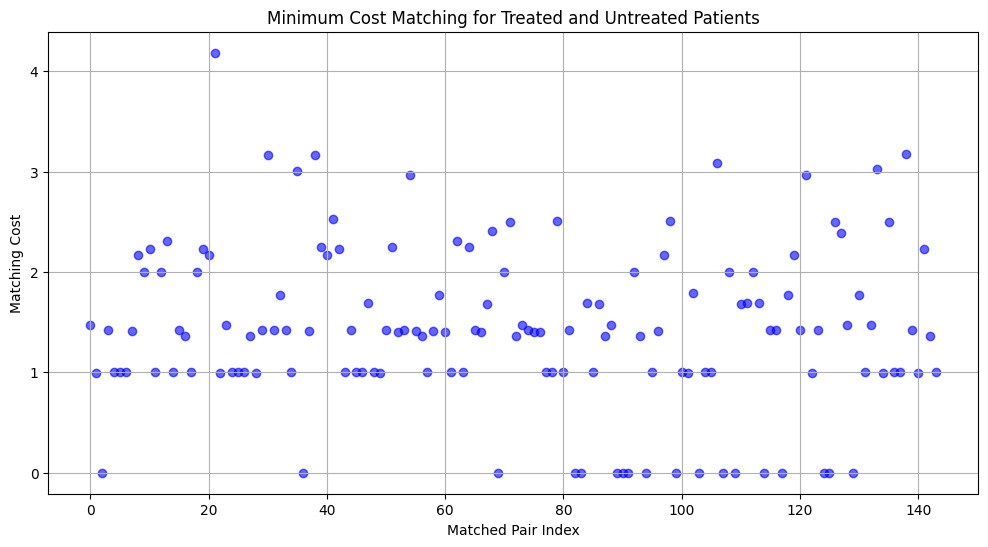

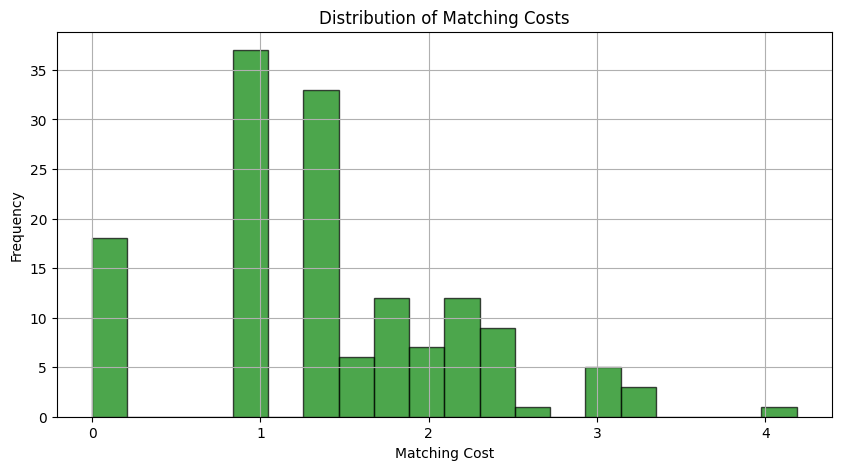

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('../Datasets/patient_treatment_data.csv')

# Convert Treatment_Time to datetime
df['Treatment_Time'] = pd.to_datetime(df['Treatment_Time'])

# Separate treated and untreated patients
treated = df[df['Treated'] == 'Yes'].reset_index(drop=True)
untreated = df[df['Treated'] == 'No'].reset_index(drop=True)

# Define symptom columns
symptom_columns = ['Pain_Score', 'Urgency_Score', 'Frequency_Score']

# Standardize the symptom scores
scaler = StandardScaler()
df[symptom_columns] = scaler.fit_transform(df[symptom_columns])

# Compute covariance matrix and its inverse
cov_matrix = np.cov(df[symptom_columns], rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Function to compute Mahalanobis distance
def mahalanobis_distance(row1, row2, columns, inv_cov_matrix):
    diff = row1[columns] - row2[columns]
    return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

# Compute cost matrix for Hungarian algorithm
cost_matrix = np.zeros((len(treated), len(untreated)))
for i in range(len(treated)):
    for j in range(len(untreated)):
        cost_matrix[i, j] = mahalanobis_distance(treated.iloc[i], untreated.iloc[j], symptom_columns, inv_cov_matrix)

# Hungarian Algorithm for optimal balanced matching
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct flow network
G = nx.DiGraph()

# Add source and sink
source = "source"
sink = "sink"
G.add_node(source, demand=-len(row_ind))  # Supply for treated patients
G.add_node(sink, demand=len(row_ind))  # Demand for untreated patients

# Add treated patients as supply nodes
for i in range(len(treated)):
    G.add_node(f"Treated_{i}", demand=-1)
    G.add_edge(source, f"Treated_{i}", capacity=1, weight=0)  # Zero cost from source

# Add untreated patients as demand nodes
for j in range(len(untreated)):
    G.add_node(f"Untreated_{j}", demand=1)
    G.add_edge(f"Untreated_{j}", sink, capacity=1, weight=0)  # Zero cost to sink

# Add edges with Mahalanobis distance as costs
for i, j in zip(row_ind, col_ind):
    cost = cost_matrix[i, j]
    G.add_edge(f"Treated_{i}", f"Untreated_{j}", capacity=1, weight=cost)

# Solve the min-cost flow problem
try:
    flow_cost, flow_dict = nx.network_simplex(G)
    print("Minimum Cost Flow solution found!")
    print("Total flow cost:", flow_cost)
except nx.NetworkXUnfeasible:
    print("No feasible solution exists.")
    flow_dict = {}

# Extract matched pairs from flow solution
matched_pairs = []
for i, j in zip(row_ind, col_ind):
    matched_pairs.append({
        'Treated_ID': treated.iloc[i]['ID'],
        'Treated_Pain_Score': treated.iloc[i]['Pain_Score'],
        'Treated_Urgency_Score': treated.iloc[i]['Urgency_Score'],
        'Treated_Frequency_Score': treated.iloc[i]['Frequency_Score'],
        'Untreated_ID': untreated.iloc[j]['ID'],
        'Untreated_Pain_Score': untreated.iloc[j]['Pain_Score'],
        'Untreated_Urgency_Score': untreated.iloc[j]['Urgency_Score'],
        'Untreated_Frequency_Score': untreated.iloc[j]['Frequency_Score'],
        'Matching_Cost': cost_matrix[i, j]  # Mahalanobis distance
    })

# Convert matched pairs to DataFrame
matched_pairs_df = pd.DataFrame(matched_pairs)

# Display matched pairs
print(":: MINIMUM COST MATCHED PAIRS")
print(matched_pairs_df)

# Visualization: Compare before and after matching
plt.figure(figsize=(15, 5))

# Plot Pain_Score distribution
plt.subplot(1, 3, 1)
plt.hist([treated['Pain_Score'], untreated['Pain_Score'], matched_pairs_df['Treated_Pain_Score'], matched_pairs_df['Untreated_Pain_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Pain Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Urgency_Score distribution
plt.subplot(1, 3, 2)
plt.hist([treated['Urgency_Score'], untreated['Urgency_Score'], matched_pairs_df['Treated_Urgency_Score'], matched_pairs_df['Untreated_Urgency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Urgency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Frequency_Score distribution
plt.subplot(1, 3, 3)
plt.hist([treated['Frequency_Score'], untreated['Frequency_Score'], matched_pairs_df['Treated_Frequency_Score'], matched_pairs_df['Untreated_Frequency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Frequency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Scatter plot of matching cost per treated patient
plt.figure(figsize=(12, 6))
plt.scatter(range(len(matched_pairs_df)), matched_pairs_df['Matching_Cost'], color='blue', alpha=0.6)
plt.xlabel('Matched Pair Index')
plt.ylabel('Matching Cost')
plt.title('Minimum Cost Matching for Treated and Untreated Patients')
plt.grid(True)
plt.show()

# Histogram to visualize distribution of matching costs
plt.figure(figsize=(10, 5))
plt.hist(matched_pairs_df['Matching_Cost'], bins=20, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Matching Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Matching Costs')
plt.grid(True)
plt.show()
